# Example: Using `stco` to Analyze Minnesota Accidents

`stco` or Spatiotemporal Cluster Overlay is a Python package designed to make use of A-DBSCAN for point clustering on many snapshots or periods of time, to get a better sense of how clusters change over time. Rather than including the temporal dimension directly in the algorithm, like [ST-DBSCAN](https://doi.org/10.1016/j.datak.2006.01.013), and then having to define a temporal distance to find clusters, using the spatial overlay allows us to explore the dynamics of the underlying clusters in a more intuitive and explainable manner. Rather than actually finding spatiotemporal clusters, we can find spatial clusters at time steps and then see how they change throughout time. Both simple and weighted overlays are available to use. Classifying the overlapping cluster footprints into classes is also made possible through the `STCEC` (Spatiotemporal Cluster Evolution Classifier) framework which categorizes clusters based on the characteristics of when the cluster has been included as a cluster across the different time periods.

In this notebook, the aforementioned methods will be explored in the context of traffic accidents in Minnesota from January 2017 to September 2023.

In [1]:
# Imports
import contextily as ctx
import geopandas as gpd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Import STCO Locally
import os
import sys

sys.path.append(os.path.abspath(".."))

from stco.clustering import TemporalADBSCAN
from stco.overlay import simple_overlay, stcec, weighted_overlay

## Data Retrieval

In these cells, let's get our dataset and loaded into a GeoDataFrame and take a look at it!

In [3]:
# Read in File
incidents = gpd.read_file("mn_accidents.geojson")

incidents.head()

,icr,incident_type,incident_date,district,location_description,road_condition,vehicles_involved,city_id,geometry
0,20601015,Injury,2020-03-04 07:35:00,2600 St. Cloud,"Highway 4 at County Road 28, Danielson Twp, Me...",Dry,2,2,POINT (-94.69653 45.03705)
1,17901947,Injury,2017-09-09 18:39:00,2900 Detroit Lakes,"Eastbound Hwy 10 between Bluffton and Wadena, ...",Dry,1,3,POINT (-95.23377 46.46705)
2,20902058,Injury,2020-12-07 16:30:00,2900 Detroit Lakes,"Westbound Hwy 10 MP87, BLUFFTON TWP, Otter Tai...",Dry,1,3,POINT (-95.24486 46.46791)
3,19901575,Injury,2019-07-28 13:28:00,2900 Detroit Lakes,"10 Highway / 77 County Road, Bluffton, Otter T...",Wet,1,3,POINT (-95.23459 46.46810)
4,17900227,Injury,2017-01-21 10:58:00,2900 Detroit Lakes,"East bound Hwy 10 west of Bluffton, Bluffton T...",Wet,3,3,POINT (-95.24486 46.46791)


In [4]:
# Check Data Types
incidents.dtypes

icr                              int64
incident_type                   object
incident_date           datetime64[ns]
district                        object
location_description            object
road_condition                  object
vehicles_involved                int64
city_id                          int64
geometry                      geometry
dtype: object

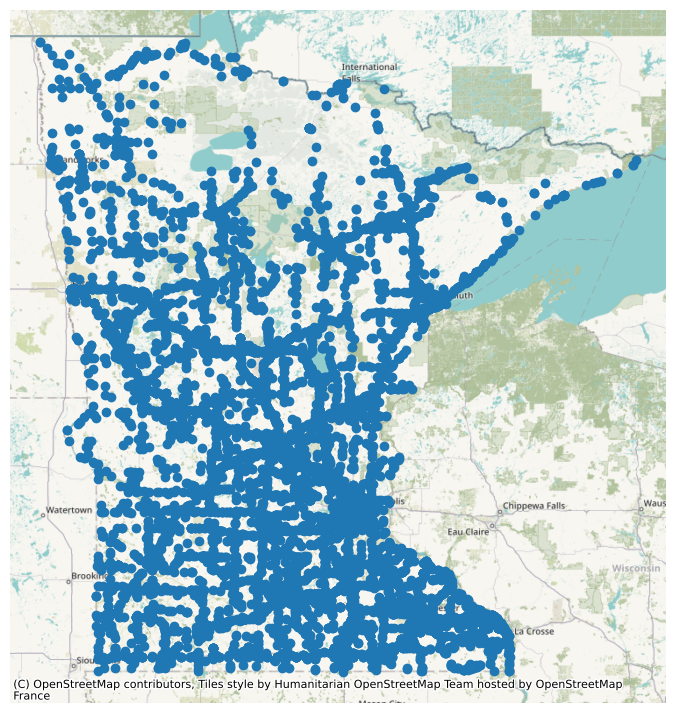

In [5]:
# Plotting Incident Points
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

incidents.to_crs(epsg=3857).plot(ax=ax)
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

## Clustering
Now that the data is ready to go, we can set up the ADBSCAN clustering model that we want to use for each period/snapshot of time. In this case, the analysis will look at the yearly time periods.

It's important to note that the min_sample_pct parameter differs from how `esda` implements ADBSCAN. Specifically in TemporalADBSCAN, a percentage of the number of records is used, rather than a raw count like `esda` uses for ADBSCAN. See notebook `03-selecting-adbscan-params.ipynb` for more information.

In [6]:
# Creating Temporal ADBSCAN
tadbs = TemporalADBSCAN(
    data=incidents,
    period="Y",
    eps=0.15,
    min_sample_pct=0.01,
    time_field="incident_date",
    pct_exact=0.5,
    reps=50,
    keep_solus=True,
)

In [7]:
# Fit
clusters = tadbs.fit_all()

clusters.head()

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:06<00:04,  1.41s/it]/Users/lukezaruba/Documents/Projects/stco/.env/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:535: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  multipoint = ops.cascaded_union([geom.Point(xy) for xy in xys])
100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


,PERIOD,geometry
0,2020,"POLYGON ((-94.00187 45.23214, -94.00489 45.232..."
1,2020,"POLYGON ((-94.99025 45.74774, -94.96442 45.813..."
12,2020,"POLYGON ((-94.37573 44.83054, -94.39616 44.863..."
3,2020,"POLYGON ((-92.16326 46.73652, -92.19395 46.735..."
4,2020,"POLYGON ((-93.24893 44.37786, -93.27561 44.312..."


## Overlay Analysis
Now that all of the cluster footprints have been created across the different time periods, overlay analysis can be used to further examine the temporal stability of the clusters.

There are two approaches used:
1. Simple Overlay
2. Weighted Overlay

The simple overlay looks at all the intersecting areas between clusters and calculates the total number of times an area was included in a cluster (the number of footprints that are overlapping at a given area). The maximum theoretical value that could exist in the output is the total number of cluster footprints that exist in the input, since there could be an are where every single footprint overlaps.

The weighted overlay expands upon this idea, by giving higher weights/preference to more recent clusters. For each overlapping area of clusters the weights of the individual clusters are summed, to create a total weight. Each individual weight is calculated as the time period's index ($1$ being the least recent, $n$ being the most recent) and divides it by the sum of all the indexes. Mathematically, this can be defined as $ \sum \limits _{i=1} ^{n} i $.
The maximum value that could exist in the output of the weighted overlay is $1$ since the values are normalized. This would be indicative of an area that is included in 100% of the time periods, **not necessarily 100% of the individual cluster footprints**.

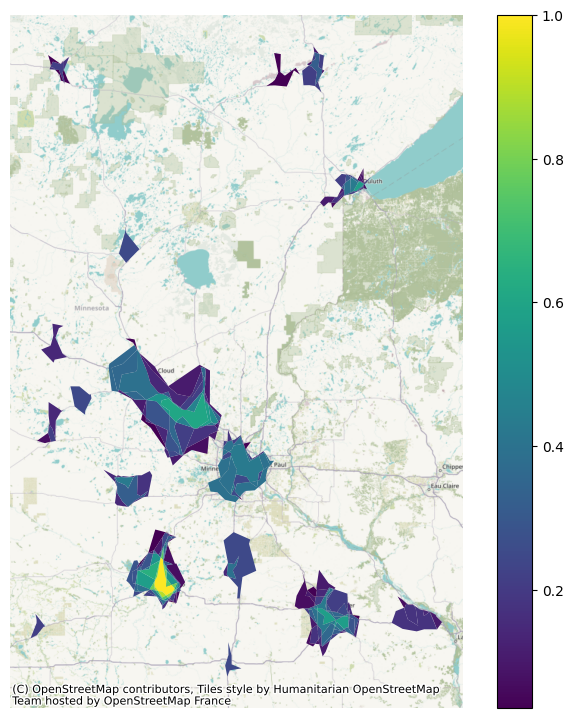

In [8]:
# Weighted Overlay
wo = weighted_overlay(clusters.copy())

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

wo = wo.set_crs(epsg=4326)
wo.to_crs(epsg=3857).plot(column="WEIGHT", legend=True, ax=ax)
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

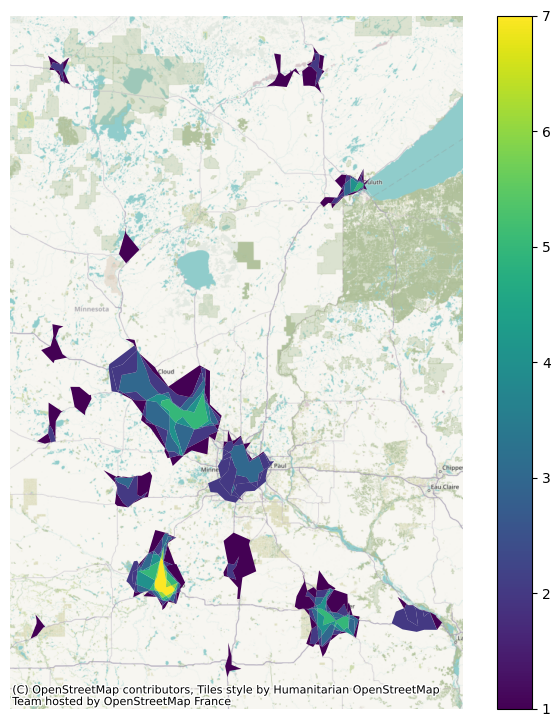

In [9]:
# Simple Overlay
so = simple_overlay(clusters.copy())

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

so = so.set_crs(epsg=4326)
so.to_crs(epsg=3857).plot(column="COUNT", legend=True, ax=ax)
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

## Spatiotemporal Classification

Using a method called STCEC, or Spatiotemporal Cluster Evolution Classifier, the areas of overlap can be further analyzed by examining the patterns of when each area was classified as a cluster. We can start to see trends like, which areas are only recently being included in clusters or which areas used to be included in clusters but aren't anymore.

This idea builds off of the idea behind Esri's [Emerging Hot Spot](https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/learnmoreemerging.htm) tool, but can be used for point clusters rather than a Space Time Cube. As a result, we are only able to look at hotspots and have to change some of the logic beind what defines certain types of hotspots.

The definitions used by `stco` are as follows:

Users are able to define a percentage threshold that can be used to separate clusters that have been continuously included as clusters. Meaning that, given a percentage $n$, areas that are included in at least $n$% of all time periods are considered to be historically significant.

- **Persistent** >= $n$% inclusion, Most recent step included
- **Historical** >= $n$% inclusion, Most recent step not included
- **New** < $n$% inclusion, Most recent step included, Only included once
- **Sporadic** < $n$% inclusion, Most recent step not included, Only included once
- **Intensifying** < $n$% inclusion, Most recent & second most recent steps included, Included > 1
- **Diminishing** < $n$% inclusion, Most recent & second most recent steps not included, Included > 1, Must be some consecutive streak
- **Occasional** < $n$% inclusion, Most recent step not included, Included > 1

KeyError: 319 not found


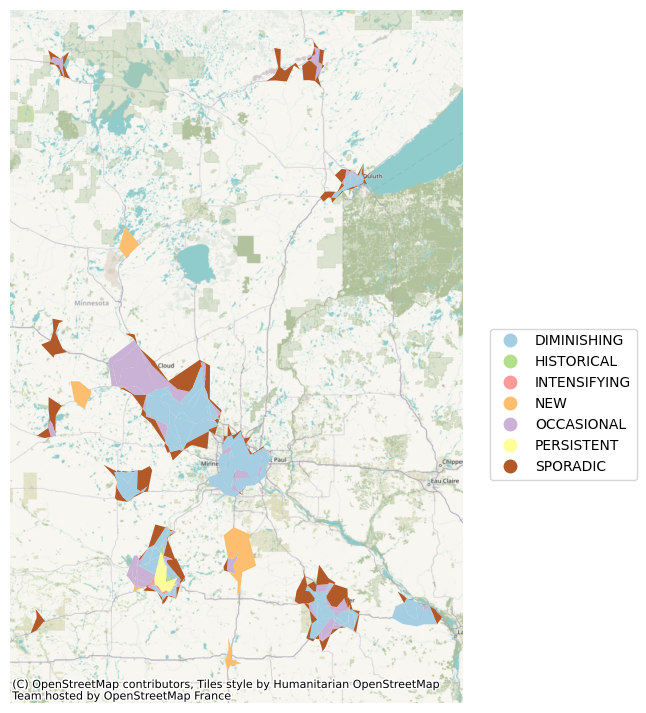

In [10]:
# STCEC
st_classes = stcec(clusters.copy(), significance_percent=0.8)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

st_classes = st_classes.set_crs(epsg=4326)
st_classes.to_crs(epsg=3857).plot(
    column="STCEC",
    cmap="Paired",
    legend=True,
    ax=ax,
    legend_kwds={"bbox_to_anchor": (1.4, 0.55)},
)
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()